In [1]:
import copy
import os
import random
import uuid
from dataclasses import asdict, dataclass
from pathlib import Path

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt


import d4rl
import gymnasium as gym
import numpy as np
import pyrallis
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

import sys
sys.path.append('../scripts')
import pickle
from tensordict import MemoryMappedTensor, TensorDict
from actor_utils import *
from iql_debug import ImplicitQLearning, TwinQ
from utils import *

No module named 'flow'
No module named 'carla'
pybullet build time: Nov 28 2023 23:45:17


## Load trained offline-rl policy and evaluate. ##

In [2]:
checkpoints_path = "/home/lucas/Workspace/CORL/out"
run_name = "IQL-evasion-v0-1cda0adf"
model_dict = torch.load(os.path.join(checkpoints_path, run_name, "checkpoint.pt"))

In [3]:
# Set environment parameters.
img_size = 100
time_max = 100
observation_img_size = [1, img_size, img_size]
action_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,))
observation_space= gym.spaces.Dict({"heat_map": gym.spaces.Box(0, 255, observation_img_size), 
                        "goal_direction": gym.spaces.Box(-250, 250, shape=(2,)),
                        'time_spent': gym.spaces.Discrete(time_max + 1)})
action_dim = 1

In [4]:
model_dict

{'qf': OrderedDict([('feature_extractor.extractors.heat_map.cnn.0.weight',
               tensor([[[[ 0.0453,  0.0859, -0.0865,  ...,  0.1010, -0.0142,  0.0464],
                         [ 0.0809, -0.0738, -0.1281,  ..., -0.0486,  0.0219,  0.0155],
                         [ 0.0263, -0.1050, -0.0631,  ..., -0.1077,  0.0490,  0.0368],
                         ...,
                         [ 0.0848, -0.0326,  0.0290,  ..., -0.0142, -0.0232, -0.0557],
                         [ 0.0170, -0.1315, -0.0947,  ..., -0.0656, -0.0143,  0.0198],
                         [-0.0665, -0.1471, -0.0893,  ..., -0.0887, -0.1047, -0.0677]]],
               
               
                       [[[ 0.0472,  0.0420, -0.0259,  ...,  0.1233,  0.1908,  0.0920],
                         [ 0.1664,  0.1616,  0.0392,  ...,  0.1100,  0.1598,  0.1862],
                         [-0.0547,  0.1413, -0.0321,  ...,  0.0508,  0.1044,  0.1297],
                         ...,
                         [ 0.0003,  0.1373, -0.0

### Load Q network ###

In [5]:
q_network = TwinQ(observation_space, action_dim)
q_network.load_state_dict(model_dict['qf'])
q_network.eval()

TwinQ(
  (feature_extractor): FeatureExtractor(
    (extractors): ModuleDict(
      (goal_direction): Flatten(start_dim=1, end_dim=-1)
      (heat_map): NatureCNN(
        (cnn): Sequential(
          (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (linear): Sequential(
          (0): Linear(in_features=5184, out_features=256, bias=True)
          (1): ReLU()
        )
      )
      (time_spent): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (q1): MLP(
    (net): Sequential(
      (0): Linear(in_features=260, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
      (5): Squeeze()
    )


In [6]:
# Set up neural network modules.
actor = ActorNet(observation_space, action_space, [64, 64])
actor.load_state_dict(model_dict['actor'])
actor.eval()

ActorNet(
  (feature_extractor): FeatureExtractor(
    (extractors): ModuleDict(
      (goal_direction): Flatten(start_dim=1, end_dim=-1)
      (heat_map): NatureCNN(
        (cnn): Sequential(
          (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (linear): Sequential(
          (0): Linear(in_features=5184, out_features=256, bias=True)
          (1): ReLU()
        )
      )
      (time_spent): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (policy_net): Sequential(
    (0): Linear(in_features=259, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (action_net): Linear(in_features=64, out_features=1, bias=True)
)

### Load one of the training data ###

In [7]:
episode_idx = 2
data_path = "/home/lucas/Workspace/Guidance for Evasion/data/"
episode_dict = np.load(data_path + f'episode_{episode_idx}.npy',allow_pickle='TRUE').item()

In [8]:
delta_t = 0.5
V = 30
radar_radius = 100
aircraft_detection_range = 150
grid_size=2*aircraft_detection_range/img_size

state_cur = episode_dict['start_state']
radar_locs = episode_dict['radar_locations']
radar_orientations = episode_dict['radar_orientations']
goal_location = episode_dict['goal_location']
time_spent = 0

trajectory = [state_cur]
q_values = []
with torch.no_grad():
    while np.linalg.norm(state_cur[:2] - goal_location) > 30:
        print("Time spent: ", time_spent)
        if time_spent > 100:
            print("Reached time limit.")
            break
        obs = TensorDict({
            'heat_map': torch.from_numpy(get_radar_heat_map(state_cur, radar_locs, img_size,
                                           aircraft_detection_range,
                                           grid_size, 
                                           radar_radius)).unsqueeze(dim=0).float(),
            'goal_direction': torch.from_numpy(goal_location - state_cur[:2]).unsqueeze(dim=0).float(),
            'time_spent': torch.from_numpy(np.asarray([np.exp(time_spent/50)])).unsqueeze(dim=0).float()
        })
        # print(obs)
        # print("State: ", state_cur)
        u, u_distribution = actor(obs)
        q_values.append(q_network(obs, u))
        # print("State: ", state_cur)
        state_cur = state_cur + delta_t*np.array([V*np.cos(state_cur[2]), V*np.sin(state_cur[2]), u.flatten().numpy()[0]/V])
        # print(state_cur)
        time_spent += 1
        trajectory.append(state_cur)
trajectory = np.asarray(trajectory)

Time spent:  0
Time spent:  1
Time spent:  2
Time spent:  3
Time spent:  4
Time spent:  5
Time spent:  6
Time spent:  7
Time spent:  8
Time spent:  9
Time spent:  10
Time spent:  11
Time spent:  12
Time spent:  13
Time spent:  14
Time spent:  15
Time spent:  16
Time spent:  17
Time spent:  18
Time spent:  19
Time spent:  20
Time spent:  21
Time spent:  22
Time spent:  23
Time spent:  24
Time spent:  25
Time spent:  26
Time spent:  27
Time spent:  28
Time spent:  29
Time spent:  30
Time spent:  31
Time spent:  32
Time spent:  33
Time spent:  34
Time spent:  35
Time spent:  36
Time spent:  37
Time spent:  38
Time spent:  39
Time spent:  40
Time spent:  41
Time spent:  42
Time spent:  43
Time spent:  44
Time spent:  45
Time spent:  46
Time spent:  47
Time spent:  48
Time spent:  49
Time spent:  50
Time spent:  51
Time spent:  52
Time spent:  53
Time spent:  54
Time spent:  55
Time spent:  56
Time spent:  57
Time spent:  58
Time spent:  59
Time spent:  60
Time spent:  61
Time spent:  62
Ti

### Visualize the result ###

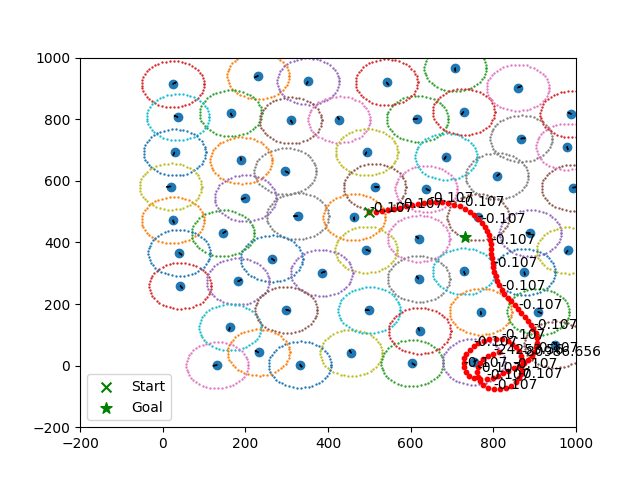

In [12]:
plt.close()
fig, ax = plt.subplots()
visualiza_radar_config(radar_locs, radar_orientations, radius=75, xlim=[0, 500], ylim=[0, 500])


ax.scatter(trajectory[:, 0], trajectory[:, 1], s=10, c='r')
for i, q_val in enumerate(q_values):
    if i % 5 == 0:
        ax.annotate(int(1000*q_val[0].numpy())/1000, (trajectory[i, 0], trajectory[i, 1]))
ax.scatter(episode_dict['start_state'][0], episode_dict['start_state'][1], s=50, c='g', marker='x', label="Start")
ax.scatter(goal_location[0], goal_location[1], s=70, c='g', marker='*', label='Goal')

ax.set_xlim(-200, 1000)
ax.set_ylim(-200, 1000)
ax.legend()
plt.show()

In [10]:
q_values

[tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),
 tensor([-0.1074]),


In [11]:
goal_location

array([732.28974342, 416.19922977])